# 4.5 Pythonによる分析の準備

In [97]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import itertools
pd.set_option("display.unicode.east_asian_width", True)
pd.set_option("display.precision", 3)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install japanize-matplotlib
import japanize_matplotlib
japanize_matplotlib.japanize()

# 4.6 意思決定にかかわる要素の整理

In [98]:
# I型情報 P(z|θ)
conditional_state = pd.DataFrame({
    "検査－問題なし": [0.8, 0.1], 
    "検査－問題あり": [0.2, 0.9]
})
conditional_state.index = ["問題なし", "問題あり"]
conditional_state

,検査－問題なし,検査－問題あり
問題なし,0.8,0.2
問題あり,0.1,0.9


In [99]:
# 利得行列
payoff = pd.DataFrame({
    "出荷": [10, -12], 
    "再検査": [6, -5], 
    "破棄": [-1, -1]
})
payoff.index = ["問題なし", "問題あり"]
payoff

,出荷,再検査,破棄
問題なし,10,6,-1
問題あり,-12,-5,-1


In [100]:
# 選択肢の集合A
action_list = payoff.columns.values
print(action_list)

['出荷' '再検査' '破棄']


In [101]:
# 選択肢の個数
num_action = len(action_list)
num_action

3

In [102]:
# 検査情報の集合Z
test_list = conditional_state.columns.values
print(test_list)

['検査－問題なし' '検査－問題あり']


In [103]:
# 検査情報の個数
num_test = len(test_list)
num_test

2

# 4.7 決定方式の実装

In [104]:
# 3種類の選択肢を2つ選ぶ組み合わせ
list(itertools.product(action_list, repeat = num_test))

[('出荷', '出荷'),
 ('出荷', '再検査'),
 ('出荷', '破棄'),
 ('再検査', '出荷'),
 ('再検査', '再検査'),
 ('再検査', '破棄'),
 ('破棄', '出荷'),
 ('破棄', '再検査'),
 ('破棄', '破棄')]

In [105]:
# 決定方式の組み合わせの数は選択肢の個数をテスト結果の個数で累乗することで得られる
range_idx = np.arange(1, num_action ** num_test + 1, 1)
range_idx

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [106]:
# 決定方式を識別するインデックス
idx = np.char.add("d", range_idx.astype("str"))
idx

array(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9'], dtype='<U22')

In [107]:
# 決定方式一覧
decision_func_set = pd.DataFrame(list(itertools.product(action_list, repeat = num_test)))
decision_func_set.index = idx
decision_func_set = decision_func_set.T
decision_func_set.index = test_list
decision_func_set

,d1,d2,d3,d4,d5,d6,d7,d8,d9
検査－問題なし,出荷,出荷,出荷,再検査,再検査,再検査,破棄,破棄,破棄
検査－問題あり,出荷,再検査,破棄,出荷,再検査,破棄,出荷,再検査,破棄


In [108]:
# 任意の決定方式を抽出
decision_func = decision_func_set["d2"]
decision_func

検査－問題なし      出荷
検査－問題あり    再検査
Name: d2, dtype: object

In [109]:
# 決定方式d2を採用したときの利得行列
decision_result = payoff[decision_func]
decision_result

,出荷,再検査
問題なし,10,6
問題あり,-12,-5


# 4.8 決定方式別の，自然の状態の条件付き期待金額

In [110]:
# pandasのdataframeをnumpyのndarrayに変換しておく
probs_array = conditional_state.values # P(z|θ)
payoff_array = decision_result.values  # 決定方式d2を採用した時の利得行列

In [111]:
# 自然の状態がθ1のときの条件付き分布P(z|θ1)
probs_array[0,]

array([0.8, 0.2])

In [112]:
# 自然の状態がθ1のときの利得ベクトル
payoff_array[0,]

array([10,  6])

In [113]:
# 両者をかけて和をとると期待値が得られる
np.sum(probs_array[0,] * payoff_array[0,])

9.2

In [114]:
# 自然の状態θ1とθ2をまとめて計算する
np.sum(probs_array * payoff_array, axis = 1)

array([ 9.2, -5.7])

In [115]:
# 決定方式ごとに期待金額を求める関数
def decision_func_emv(decision_func, probs, payoff_table):

  # 決定関数に基づいて行動した時の利得行列
  decision_result = payoff_table[decision_func]

  # ndarrayに変換
  probs_array = probs.values
  payoff_array = decision_result.values

  # 自然の状態別期待金額
  emv = np.sum(probs_array * payoff_array, axis = 1)

  return emv

In [116]:
# 関数の動作確認
decision_func_emv(decision_func, conditional_state, payoff)

array([ 9.2, -5.7])

In [117]:
# decision_func_setに対してまとめて適用
risk_table = decision_func_set.apply(decision_func_emv, probs = conditional_state, payoff_table = payoff, axis = 0)
risk_table.index = payoff.index
risk_table

,d1,d2,d3,d4,d5,d6,d7,d8,d9
問題なし,10.0,9.2,7.8,6.8,6.0,4.6,1.2,0.4,-1.0
問題あり,-12.0,-5.7,-2.1,-11.3,-5.0,-1.4,-10.9,-4.6,-1.0


# 4.9 許容的・非許容的な決定方式

In [118]:
# 非許容的な決定方式
inadmissible_decision = ["d4", "d5", "d7", "d8"]
decision_func_set[inadmissible_decision]

,d4,d5,d7,d8
検査－問題なし,再検査,再検査,破棄,破棄
検査－問題あり,出荷,再検査,出荷,再検査


In [119]:
# 許容的な決定方式
admissible_decision = ["d1", "d2", "d3", "d6", "d9"]
decision_func_set[admissible_decision]

,d1,d2,d3,d6,d9
検査－問題なし,出荷,出荷,出荷,再検査,破棄
検査－問題あり,出荷,再検査,破棄,破棄,破棄


# 4.10 決定方式の視覚的な評価

In [120]:
# risk_tableの行と列を入れ替える
risk_table_t = risk_table.T
risk_table_t

,問題なし,問題あり
d1,10.0,-12.0
d2,9.2,-5.7
d3,7.8,-2.1
d4,6.8,-11.3
d5,6.0,-5.0
d6,4.6,-1.4
d7,1.2,-10.9
d8,0.4,-4.6
d9,-1.0,-1.0


In [121]:
# 各データ点が含まれる最小の図形
hull = ConvexHull(risk_table_t)

In [122]:
# 列名と値をセットにしたリスト
list(risk_table_t.iterrows())

[('d1', 問題なし    10.0
  問題あり   -12.0
  Name: d1, dtype: float64), ('d2', 問題なし    9.2
  問題あり   -5.7
  Name: d2, dtype: float64), ('d3', 問題なし    7.8
  問題あり   -2.1
  Name: d3, dtype: float64), ('d4', 問題なし     6.8
  問題あり   -11.3
  Name: d4, dtype: float64), ('d5', 問題なし    6.0
  問題あり   -5.0
  Name: d5, dtype: float64), ('d6', 問題なし    4.6
  問題あり   -1.4
  Name: d6, dtype: float64), ('d7', 問題なし     1.2
  問題あり   -10.9
  Name: d7, dtype: float64), ('d8', 問題なし    0.4
  問題あり   -4.6
  Name: d8, dtype: float64), ('d9', 問題なし   -1.0
  問題あり   -1.0
  Name: d9, dtype: float64)]

Text(0, 0.5, '「問題あり」のときの期待金額')

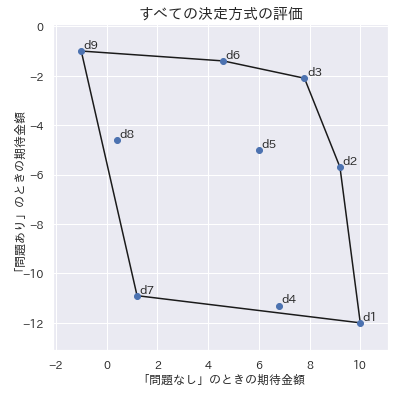

In [123]:
# 横軸が問題なしのときの期待金額，縦軸が問題ありのときの期待金額
fig, ax = plt.subplots(figsize = (6, 6))
plot = convex_hull_plot_2d(hull, ax)
for text, xy in risk_table_t.iterrows():
  ax.annotate(text, xy = xy, xytext = xy + 0.1)
ax.set_title("すべての決定方式の評価", fontsize = 15)
ax.set_xlabel("「問題なし」のときの期待金額")
ax.set_ylabel("「問題あり」のときの期待金額")

# 4.11 混合決定方式

In [124]:
# コインを投げて表が出たらd2を，裏が出たらd3を採用する場合の期待利得
risk_table[["d2", "d3"]].mean(axis = 1)

問題なし    8.5
問題あり   -3.9
dtype: float64

# 4.13 検査情報を使わないときの期待金額

In [125]:
# 「問題なし」の事前確率P(θ1)は0～1の範囲をとる
p_df = pd.DataFrame(np.array([np.arange(0, 1.01, 0.01), 1 - np.arange(0, 1.01, 0.01)]))
p_df.index = payoff.index
p_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
問題なし,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0
問題あり,1.0,0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,...,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01,0.0


In [126]:
# 選択肢「出荷」を選択したときの利得
payoff["出荷"]

問題なし    10
問題あり   -12
Name: 出荷, dtype: int64

In [127]:
# 事前確率で重み付けられた金額
p_df.mul(payoff["出荷"], axis = 0)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
問題なし,0.0,0.10,0.20,0.30,0.40,0.5,0.60,0.70,0.80,0.90,...,9.10,9.20,9.30,9.40,9.5,9.60,9.70,9.80,9.90,10.0
問題あり,-12.0,-11.88,-11.76,-11.64,-11.52,-11.4,-11.28,-11.16,-11.04,-10.92,...,-1.08,-0.96,-0.84,-0.72,-0.6,-0.48,-0.36,-0.24,-0.12,-0.0


In [128]:
# 列ごとに和をとる＝期待値
p_df.mul(payoff["出荷"], axis = 0).sum(axis = 0)

0     -12.00
1     -11.78
2     -11.56
3     -11.34
4     -11.12
       ...  
96      9.12
97      9.34
98      9.56
99      9.78
100    10.00
Length: 101, dtype: float64

In [129]:
# 利得行列を所与として，P(θ1)で重み付けられた期待金額を出力する関数
def make_emv_list(payoff):

  # 「問題あり」が発生する事前確率
  p_df = pd.DataFrame(np.array([np.arange(0, 1.01, 0.01), 1 - np.arange(0, 1.01, 0.01)]))
  p_df.index = payoff.index

  # 事前確率で重み付けられた期待金額
  emv = p_df.mul(payoff, axis = 0).sum(axis = 0)

  return emv

In [130]:
# 動作確認
make_emv_list(payoff["出荷"])

0     -12.00
1     -11.78
2     -11.56
3     -11.34
4     -11.12
       ...  
96      9.12
97      9.34
98      9.56
99      9.78
100    10.00
Length: 101, dtype: float64

In [131]:
# 各選択肢についてまとめて計算
no_data_emv = payoff.apply(make_emv_list)
no_data_emv

,出荷,再検査,破棄
0,-12.00,-5.00,-1.0
1,-11.78,-4.89,-1.0
2,-11.56,-4.78,-1.0
3,-11.34,-4.67,-1.0
4,-11.12,-4.56,-1.0
...,...,...,...
96,9.12,5.56,-1.0
97,9.34,5.67,-1.0
98,9.56,5.78,-1.0
99,9.78,5.89,-1.0


In [132]:
# 期待金額と判断確率P(θ1)をまとめたデータフレーム
no_data_emv_p = no_data_emv.copy()
no_data_emv_p["p_theta"] = np.arange(0, 1.01, 0.01)
no_data_emv_p

,出荷,再検査,破棄,p_theta
0,-12.00,-5.00,-1.0,0.00
1,-11.78,-4.89,-1.0,0.01
2,-11.56,-4.78,-1.0,0.02
3,-11.34,-4.67,-1.0,0.03
4,-11.12,-4.56,-1.0,0.04
...,...,...,...,...
96,9.12,5.56,-1.0,0.96
97,9.34,5.67,-1.0,0.97
98,9.56,5.78,-1.0,0.98
99,9.78,5.89,-1.0,0.99


Text(0, 0.5, '期待金額')

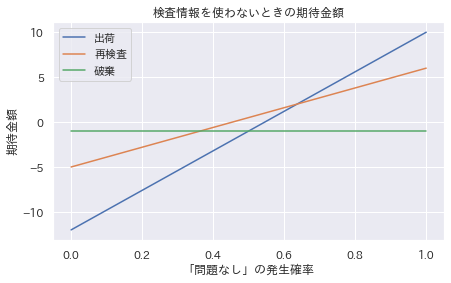

In [133]:
# 可視化
fig, ax = plt.subplots(figsize = (7, 4))
no_data_emv_p.plot(x = "p_theta", ax = ax)
ax.set_title("検査情報を使わないときの期待金額")
ax.set_xlabel("「問題なし」の発生確率")
ax.set_ylabel("期待金額")

# 4.14 検査情報を使うときの期待金額

In [134]:
# 許容的な決定方式の自然の状態別期待金額
risk_table[admissible_decision]

,d1,d2,d3,d6,d9
問題なし,10.0,9.2,7.8,4.6,-1.0
問題あり,-12.0,-5.7,-2.1,-1.4,-1.0


In [135]:
# 検査情報を使う場合の期待金額
use_data_emv = risk_table[admissible_decision].apply(make_emv_list)
use_data_emv

,d1,d2,d3,d6,d9
0,-12.00,-5.700,-2.100,-1.40,-1.0
1,-11.78,-5.551,-2.001,-1.34,-1.0
2,-11.56,-5.402,-1.902,-1.28,-1.0
3,-11.34,-5.253,-1.803,-1.22,-1.0
4,-11.12,-5.104,-1.704,-1.16,-1.0
...,...,...,...,...,...
96,9.12,8.604,7.404,4.36,-1.0
97,9.34,8.753,7.503,4.42,-1.0
98,9.56,8.902,7.602,4.48,-1.0
99,9.78,9.051,7.701,4.54,-1.0


In [136]:
# 期待金額と判断確率P(θ1)をまとめたデータフレーム
use_data_emv_p = use_data_emv.copy()
use_data_emv_p["p_theta"] = np.arange(0, 1.01, 0.01)
use_data_emv_p

,d1,d2,d3,d6,d9,p_theta
0,-12.00,-5.700,-2.100,-1.40,-1.0,0.00
1,-11.78,-5.551,-2.001,-1.34,-1.0,0.01
2,-11.56,-5.402,-1.902,-1.28,-1.0,0.02
3,-11.34,-5.253,-1.803,-1.22,-1.0,0.03
4,-11.12,-5.104,-1.704,-1.16,-1.0,0.04
...,...,...,...,...,...,...
96,9.12,8.604,7.404,4.36,-1.0,0.96
97,9.34,8.753,7.503,4.42,-1.0,0.97
98,9.56,8.902,7.602,4.48,-1.0,0.98
99,9.78,9.051,7.701,4.54,-1.0,0.99


Text(0, 0.5, '期待金額')

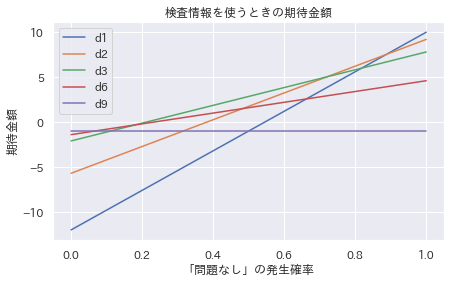

In [137]:
# 可視化
fig, ax = plt.subplots(figsize = (7, 4))
use_data_emv_p.plot(x = "p_theta", ax = ax)
ax.set_title("検査情報を使うときの期待金額")
ax.set_xlabel("「問題なし」の発生確率")
ax.set_ylabel("期待金額")

# 4.15 検査情報を使わないときの最適行動

In [138]:
# P(θ1)の値ごとに期待金額が最も大きくなる選択肢を選ぶ
no_data_best_action = no_data_emv.idxmax(axis = 1)
no_data_best_action

0      破棄
1      破棄
2      破棄
3      破棄
4      破棄
       ... 
96     出荷
97     出荷
98     出荷
99     出荷
100    出荷
Length: 101, dtype: object

In [139]:
# shift関数でデータを一行後ろにずらす
no_data_best_action.shift(1)

0       NaN
1      破棄
2      破棄
3      破棄
4      破棄
       ... 
96     出荷
97     出荷
98     出荷
99     出荷
100    出荷
Length: 101, dtype: object

In [140]:
# 最適な選択肢が変化するタイミング
no_data_act_change = no_data_best_action != no_data_best_action.shift(1)
no_data_act_change

0       True
1      False
2      False
3      False
4      False
       ...  
96     False
97     False
98     False
99     False
100    False
Length: 101, dtype: bool

In [141]:
# no_data_emvに最適行動を追加
no_data_emv_p["best_action"] = no_data_best_action
no_data_emv_p

,出荷,再検査,破棄,p_theta,best_action
0,-12.00,-5.00,-1.0,0.00,破棄
1,-11.78,-4.89,-1.0,0.01,破棄
2,-11.56,-4.78,-1.0,0.02,破棄
3,-11.34,-4.67,-1.0,0.03,破棄
4,-11.12,-4.56,-1.0,0.04,破棄
...,...,...,...,...,...
96,9.12,5.56,-1.0,0.96,出荷
97,9.34,5.67,-1.0,0.97,出荷
98,9.56,5.78,-1.0,0.98,出荷
99,9.78,5.89,-1.0,0.99,出荷


In [142]:
# 最適行動が変わるp_thetaを抽出
no_data_emv_p[no_data_act_change][["p_theta", "best_action"]]

,p_theta,best_action
0,0.00,破棄
37,0.37,再検査
64,0.64,出荷


# 4.16 検査情報を使うときの最適行動

In [143]:
# 期待金額が最も大きい決定方式を調べる
use_data_best_action = use_data_emv.idxmax(axis = 1)
use_data_best_action

0      d9
1      d9
2      d9
3      d9
4      d9
       ..
96     d1
97     d1
98     d1
99     d1
100    d1
Length: 101, dtype: object

In [144]:
# 最適行動が変わるp_thetaを調べる
use_data_act_change = use_data_best_action != use_data_best_action.shift(1)
use_data_act_change

0       True
1      False
2      False
3      False
4      False
       ...  
96     False
97     False
98     False
99     False
100    False
Length: 101, dtype: bool

In [145]:
# 最適行動の列を追加
use_data_emv_p["best_action"] = use_data_best_action
use_data_emv_p

,d1,d2,d3,d6,d9,p_theta,best_action
0,-12.00,-5.700,-2.100,-1.40,-1.0,0.00,d9
1,-11.78,-5.551,-2.001,-1.34,-1.0,0.01,d9
2,-11.56,-5.402,-1.902,-1.28,-1.0,0.02,d9
3,-11.34,-5.253,-1.803,-1.22,-1.0,0.03,d9
4,-11.12,-5.104,-1.704,-1.16,-1.0,0.04,d9
...,...,...,...,...,...,...,...
96,9.12,8.604,7.404,4.36,-1.0,0.96,d1
97,9.34,8.753,7.503,4.42,-1.0,0.97,d1
98,9.56,8.902,7.602,4.48,-1.0,0.98,d1
99,9.78,9.051,7.701,4.54,-1.0,0.99,d1


In [146]:
# 最適行動が変わるp_thetaを抽出
use_data_emv_p.loc[use_data_act_change, ["p_theta", "best_action"]]

,p_theta,best_action
0,0.00,d9
7,0.07,d6
18,0.18,d3
72,0.72,d2
89,0.89,d1


In [147]:
 # [再掲]決定方式の意味
 decision_func_set[admissible_decision]

,d1,d2,d3,d6,d9
検査－問題なし,出荷,出荷,出荷,再検査,破棄
検査－問題あり,出荷,再検査,破棄,破棄,破棄


# 4.17 検査情報の価値

In [148]:
# 情報を使わないときの最大期待金額
no_data_best_emv = no_data_emv.max(axis = 1)
no_data_best_emv

0      -1.00
1      -1.00
2      -1.00
3      -1.00
4      -1.00
       ...  
96      9.12
97      9.34
98      9.56
99      9.78
100    10.00
Length: 101, dtype: float64

In [149]:
# 情報を使うときの最大期待金額
use_data_best_emv = use_data_emv.max(axis = 1)
use_data_best_emv

0      -1.00
1      -1.00
2      -1.00
3      -1.00
4      -1.00
       ...  
96      9.12
97      9.34
98      9.56
99      9.78
100    10.00
Length: 101, dtype: float64

In [150]:
# 情報の価値
evsi = use_data_best_emv - no_data_best_emv
evsi

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
Length: 101, dtype: float64

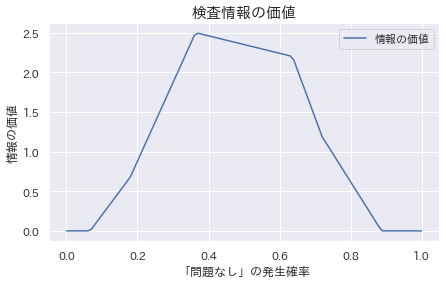

In [151]:
# 可視化
p_theta = np.arange(0, 1.01, 0.01)
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(p_theta, evsi, label = "情報の価値")
ax.set_title("検査情報の価値", fontsize = 15)
ax.set_xlabel("「問題なし」の発生確率")
ax.set_ylabel("情報の価値")
ax.legend(loc = "best")

# 4.20 事後分布の実装

In [152]:
# [再掲] 条件付き分布：P(z_k|θ_i)
conditional_state

,検査－問題なし,検査－問題あり
問題なし,0.8,0.2
問題あり,0.1,0.9


In [154]:
# 事前分布：P(θ_i)
marginal_state = pd.Series({
    "問題なし": 0.8, 
    "問題あり": 0.2
})
marginal_state

問題なし    0.8
問題あり    0.2
dtype: float64

In [156]:
# ベイズの定理の分子（＝同時分布：P(θ_i|z_k)）を計算
joint_information_state = conditional_state.mul(marginal_state, axis = 0)
joint_information_state

,検査－問題なし,検査－問題あり
問題なし,0.64,0.16
問題あり,0.02,0.18


In [157]:
# 周辺分布：P(z_k)
marginal_information = joint_information_state.sum(axis = 0)
marginal_information

検査－問題なし    0.66
検査－問題あり    0.34
dtype: float64

In [158]:
# 条件付き分布：P(θ_i|z_k)
conditional_information = joint_information_state.div(marginal_information, axis = 1)
conditional_information

,検査－問題なし,検査－問題あり
問題なし,0.97,0.471
問題あり,0.03,0.529


# 4.21 事後分布に基づく期待金額の最大化

In [159]:
# 最大値をとるインデックスを取得する関数
def argmax_list(series):
  return list(series[series == series.max()].index)

In [160]:
# 期待金額最大化に基づく意思決定を行う関数
def max_emv(probs, payoff_table):

  # 選択肢ごとの期待金額
  emv = payoff_table.mul(probs, axis = 0).sum()

  # 期待金額の最大値と最大値を与える選択肢
  max_emv = emv.max()
  a_star = argmax_list(emv)

  return pd.Series([a_star, max_emv], index = ["選択肢", "期待金額"])

In [161]:
# 事後分布に対してmax_emv関数を適用
info_decision = conditional_information.apply(max_emv, axis = 0, payoff_table = payoff)
info_decision

,検査－問題なし,検査－問題あり
選択肢,[出荷],[再検査]
期待金額,9.333,0.176


In [165]:
# P(θ_1) = 0.8のときのセクション2までで行ってきた結果
use_data_emv_p[use_data_emv_p["p_theta"] == 0.8][["p_theta", "best_action"]]

,p_theta,best_action
80,0.8,d2


In [166]:
# 決定方式d2の中身
decision_func_set["d2"]

検査－問題なし      出荷
検査－問題あり    再検査
Name: d2, dtype: object